# 04 · Comparativo SMOTE vs Class Weight
## Experimento Controlado de Técnicas de Balanceamento

<div align="center">

```
┌─────────────────────────────────────────────────────────────┐
│   BALANCING TECHNIQUES COMPARISON - EXPERIMENT v1.0        │
└─────────────────────────────────────────────────────────────┘
```

![Status](https://img.shields.io/badge/Status-Experiment%20Complete-success)
![Type](https://img.shields.io/badge/Type-Comparative%20Analysis-blue)
![Priority](https://img.shields.io/badge/Priority-HIGH-orange)

</div>

---

### OBJETIVO

Identificar a técnica ótima de balanceamento para minimizar overfitting e maximizar generalização, através de experimento controlado com 4 abordagens distintas.

### HIPÓTESE DE PESQUISA

<div style="background-color: #e7f3ff; border-left: 4px solid #2196f3; padding: 15px;">

**HIPÓTESE PRINCIPAL:**  
SMOTE cria **amostras sintéticas** que podem introduzir padrões artificiais, causando:
- Memorização da distribuição de treino
- Alta performance em treino, baixa em teste
- Falha de generalização para dados reais

**PREDIÇÃO:**  
Se SMOTE for a causa do overfitting:
- [OK] `class_weight='balanced'` → menor gap treino-teste
- [OK] Melhor PR-AUC em teste (mesmo com menor PR-AUC em treino)
- [OK] Modelo mais estável e confiável

</div>

### DESIGN EXPERIMENTAL

<table>
<tr><th>Experimento</th><th>Técnica</th><th>Complexidade</th><th>Objetivo</th></tr>
<tr><td>1</td><td>No Balancing</td><td>Baseline</td><td>Performance sem intervenção</td></tr>
<tr><td>2</td><td>Class Weight</td><td>Simples</td><td>Balanceamento algorítmico</td></tr>
<tr><td>3</td><td>SMOTE Only</td><td>Moderada</td><td>Oversampling sintético</td></tr>
<tr><td>4</td><td>SMOTE-ENN</td><td>Alta</td><td>Oversampling + Undersampling</td></tr>
</table>

### ARQUITETURA EXPERIMENTAL

```
                        ┌─────────────────┐
                        │  Dataset Base   │
                        │  (Imbalanced)   │
                        └────────┬────────┘
                                 │
                    ┌────────────┼────────────┐
                    │            │            │
         ┌──────────▼─┐    ┌────▼────┐   ┌──▼──────────┐
         │ Experiment 1│    │  Exp 2  │   │  Exp 3 & 4  │
         │ (Baseline)  │    │ (Class  │   │  (SMOTE)    │
         │ No Balance  │    │ Weight) │   │  Variants   │
         └──────┬──────┘    └────┬────┘   └──┬──────────┘
                │                │            │
                └────────────────┼────────────┘
                                 │
                        ┌────────▼────────┐
                        │  LightGBM Model │
                        │  (Same params)  │
                        └────────┬────────┘
                                 │
                        ┌────────▼────────┐
                        │  Evaluation &   │
                        │   Comparison    │
                        └─────────────────┘
```

> **CONTROLE EXPERIMENTAL:** Todos os modelos usam mesmos hiperparâmetros, mesma seed, mesma métrica de avaliação. Única variável: técnica de balanceamento.

---

In [1]:
# Environment Setup
import sys
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

sys.path.insert(0, str(Path('..') / 'utils'))

# Core imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
from datetime import datetime

# ML imports
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import (
    average_precision_score, roc_auc_score, precision_recall_curve,
    f1_score, precision_score, recall_score, confusion_matrix
)
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN

# Utils
from data import load_data, save_artifact
from metrics import pr_auc_score

# Visualization
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

# Load config
with open('../config.yaml', 'r') as f:
    CONFIG = yaml.safe_load(f)

# Paths
notebook_dir = Path('.').resolve().parent
DATA_DIR = notebook_dir / CONFIG['paths']['data']
ARTIFACTS_DIR = notebook_dir / CONFIG['paths']['artifacts']

RANDOM_STATE = CONFIG['random_state']

print("[OK] Environment configured")
print(f" Data: {DATA_DIR}")
print(f" Artifacts: {ARTIFACTS_DIR}")

[OK] Environment configured
 Data: C:\Users\gafeb\OneDrive\Desktop\lavagem_dev\data
 Artifacts: C:\Users\gafeb\OneDrive\Desktop\lavagem_dev\artifacts


## ▸ SEÇÃO 1: Carregamento e Preparação de Dados

<div style="background-color: #2d2416; border-left: 4px solid #f59e0b; padding: 15px; border-radius: 4px;">

**ESCOPO**

Carregar datasets engineered e validar distribuição de classes para experimentos controlados.

</div>

In [5]:
# Load engineered datasets
print("Loading datasets...\n")

X_train = load_data(DATA_DIR / 'X_train_engineered.csv', optimize_memory=True)
X_test = load_data(DATA_DIR / 'X_test_engineered.csv', optimize_memory=True)
y_train = pd.read_csv(DATA_DIR / 'y_train_engineered.csv').squeeze()
y_test = pd.read_csv(DATA_DIR / 'y_test_engineered.csv').squeeze()

print(f"Train: {X_train.shape}")
print(f"Test:  {X_test.shape}")
print(f"\nTrain fraud rate: {y_train.mean():.2%}")
print(f"Test fraud rate:  {y_test.mean():.2%}")
print(f"\nClass distribution:")
print(f"  Train - Fraud: {y_train.sum():,} | Normal: {(~y_train.astype(bool)).sum():,}")
print(f"  Test  - Fraud: {y_test.sum():,} | Normal: {(~y_test.astype(bool)).sum():,}")

INFO:utils.data:Loading data from X_train_engineered.csv...
INFO:utils.data:Loaded 2,400 rows, 12 columns
INFO:utils.data:Memory before optimization: 0.22 MB
INFO:utils.data:Memory after optimization: 0.07 MB (↓ 66.6%)
INFO:utils.data:Loading data from X_test_engineered.csv...
INFO:utils.data:Loaded 1,460 rows, 12 columns
INFO:utils.data:Memory before optimization: 0.13 MB
INFO:utils.data:Memory after optimization: 0.06 MB (↓ 56.2%)


Loading datasets...

Train: (2400, 12)
Test:  (1460, 12)

Train fraud rate: 25.00%
Test fraud rate:  0.96%

Class distribution:
  Train - Fraud: 600 | Normal: 1,800
  Test  - Fraud: 14 | Normal: 1,446


## ▸ SEÇÃO 2: Definição do Framework de Avaliação

<div style="background-color: #2d2416; border-left: 4px solid #f59e0b; padding: 15px; border-radius: 4px;">

**ESCOPO**

Criar função padronizada de avaliação para garantir comparação justa entre todas as técnicas.

</div>

In [6]:
def evaluate_model(X_tr, y_tr, X_te, y_te, model, strategy_name):
    """
    Train and evaluate a model, returning comprehensive metrics.
    """
    print(f"\n{'='*70}")
    print(f"Training: {strategy_name}")
    print(f"{'='*70}")
    
    # Train
    print(f"Training set: {X_tr.shape}")
    print(f"  Fraud rate: {y_tr.mean():.2%}")
    
    model.fit(X_tr, y_tr)
    
    # Predictions
    y_train_proba = model.predict_proba(X_tr)[:, 1]
    y_test_proba = model.predict_proba(X_te)[:, 1]
    
    # Metrics
    metrics = {
        'strategy': strategy_name,
        'train_samples': len(X_tr),
        'train_fraud_rate': float(y_tr.mean()),
        
        # Train metrics
        'train_pr_auc': average_precision_score(y_tr, y_train_proba),
        'train_roc_auc': roc_auc_score(y_tr, y_train_proba),
        
        # Test metrics
        'test_pr_auc': average_precision_score(y_te, y_test_proba),
        'test_roc_auc': roc_auc_score(y_te, y_test_proba),
        
        # Gap analysis
        'pr_auc_gap': None,  # Calculate below
        'roc_auc_gap': None,
        
        # Test set detailed metrics
        'test_recall': recall_score(y_te, (y_test_proba >= 0.5).astype(int)),
        'test_precision': precision_score(y_te, (y_test_proba >= 0.5).astype(int), zero_division=0),
        'test_f1': f1_score(y_te, (y_test_proba >= 0.5).astype(int), zero_division=0)
    }
    
    # Calculate gaps
    metrics['pr_auc_gap'] = metrics['train_pr_auc'] - metrics['test_pr_auc']
    metrics['roc_auc_gap'] = metrics['train_roc_auc'] - metrics['test_roc_auc']
    
    # Print results
    print(f"\n TRAIN METRICS:")
    print(f"   PR-AUC:  {metrics['train_pr_auc']:.4f}")
    print(f"   ROC-AUC: {metrics['train_roc_auc']:.4f}")
    
    print(f"\n TEST METRICS:")
    print(f"   PR-AUC:  {metrics['test_pr_auc']:.4f}")
    print(f"   ROC-AUC: {metrics['test_roc_auc']:.4f}")
    print(f"   Recall:  {metrics['test_recall']:.4f}")
    print(f"   Precision: {metrics['test_precision']:.4f}")
    print(f"   F1:      {metrics['test_f1']:.4f}")
    
    print(f"\n TRAIN-TEST GAP:")
    print(f"   PR-AUC gap:  {metrics['pr_auc_gap']:.4f} ({metrics['pr_auc_gap']/metrics['train_pr_auc']*100:.1f}% degradation)")
    print(f"   ROC-AUC gap: {metrics['roc_auc_gap']:.4f} ({metrics['roc_auc_gap']/metrics['train_roc_auc']*100:.1f}% degradation)")
    
    return metrics, model, y_test_proba

print("[OK] Evaluation function defined")

[OK] Evaluation function defined


## 3. Experiment 1 - No Balancing (Baseline)

In [7]:
# Baseline: No balancing
model_baseline = LGBMClassifier(
    n_estimators=100,
    random_state=RANDOM_STATE,
    verbose=-1
)

metrics_baseline, trained_baseline, proba_baseline = evaluate_model(
    X_train, y_train, X_test, y_test,
    model_baseline,
    "No Balancing (Baseline)"
)


Training: No Balancing (Baseline)
Training set: (2400, 12)
  Fraud rate: 25.00%

 TRAIN METRICS:
   PR-AUC:  1.0000
   ROC-AUC: 1.0000

 TEST METRICS:
   PR-AUC:  0.1263
   ROC-AUC: 0.9303
   Recall:  0.1429
   Precision: 0.3333
   F1:      0.2000

 TRAIN-TEST GAP:
   PR-AUC gap:  0.8737 (87.4% degradation)
   ROC-AUC gap: 0.0697 (7.0% degradation)


## 4. Experiment 2 - Class Weight Only

In [8]:
# Class weight approach
model_classweight = LGBMClassifier(
    n_estimators=100,
    class_weight='balanced',  # Key difference
    random_state=RANDOM_STATE,
    verbose=-1
)

metrics_classweight, trained_classweight, proba_classweight = evaluate_model(
    X_train, y_train, X_test, y_test,
    model_classweight,
    "Class Weight = Balanced"
)


Training: Class Weight = Balanced
Training set: (2400, 12)
  Fraud rate: 25.00%

 TRAIN METRICS:
   PR-AUC:  1.0000
   ROC-AUC: 1.0000

 TEST METRICS:
   PR-AUC:  0.0682
   ROC-AUC: 0.9155
   Recall:  0.0000
   Precision: 0.0000
   F1:      0.0000

 TRAIN-TEST GAP:
   PR-AUC gap:  0.9318 (93.2% degradation)
   ROC-AUC gap: 0.0845 (8.5% degradation)


## 5. Experiment 3 - SMOTE Only

In [9]:
# SMOTE approach
print(f"\n{'='*70}")
print("Applying SMOTE...")
print(f"{'='*70}")

smote = SMOTE(
    sampling_strategy={1: 600},  # From config
    random_state=RANDOM_STATE,
    k_neighbors=5
)

X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print(f"Before SMOTE: {X_train.shape}, Fraud: {y_train.sum():,}")
print(f"After SMOTE:  {X_train_smote.shape}, Fraud: {y_train_smote.sum():,}")

model_smote = LGBMClassifier(
    n_estimators=100,
    random_state=RANDOM_STATE,
    verbose=-1
)

metrics_smote, trained_smote, proba_smote = evaluate_model(
    X_train_smote, y_train_smote, X_test, y_test,
    model_smote,
    "SMOTE Only"
)


Applying SMOTE...
Before SMOTE: (2400, 12), Fraud: 600
After SMOTE:  (2400, 12), Fraud: 600

Training: SMOTE Only
Training set: (2400, 12)
  Fraud rate: 25.00%

 TRAIN METRICS:
   PR-AUC:  1.0000
   ROC-AUC: 1.0000

 TEST METRICS:
   PR-AUC:  0.1263
   ROC-AUC: 0.9303
   Recall:  0.1429
   Precision: 0.3333
   F1:      0.2000

 TRAIN-TEST GAP:
   PR-AUC gap:  0.8737 (87.4% degradation)
   ROC-AUC gap: 0.0697 (7.0% degradation)


## 6. Experiment 4 - SMOTE-ENN (Current Approach)

In [10]:
# SMOTE-ENN approach (current)
print(f"\n{'='*70}")
print("Applying SMOTE-ENN...")
print(f"{'='*70}")

smote_enn = SMOTEENN(
    random_state=RANDOM_STATE,
    sampling_strategy={1: 600},
    smote=SMOTE(random_state=RANDOM_STATE, k_neighbors=5)
)

X_train_smote_enn, y_train_smote_enn = smote_enn.fit_resample(X_train, y_train)

print(f"Before SMOTE-ENN: {X_train.shape}, Fraud: {y_train.sum():,}")
print(f"After SMOTE-ENN:  {X_train_smote_enn.shape}, Fraud: {y_train_smote_enn.sum():,}")

model_smote_enn = LGBMClassifier(
    n_estimators=100,
    random_state=RANDOM_STATE,
    verbose=-1
)

metrics_smote_enn, trained_smote_enn, proba_smote_enn = evaluate_model(
    X_train_smote_enn, y_train_smote_enn, X_test, y_test,
    model_smote_enn,
    "SMOTE-ENN (Current)"
)


Applying SMOTE-ENN...
Before SMOTE-ENN: (2400, 12), Fraud: 600
After SMOTE-ENN:  (3030, 12), Fraud: 1,620

Training: SMOTE-ENN (Current)
Training set: (3030, 12)
  Fraud rate: 53.47%

 TRAIN METRICS:
   PR-AUC:  1.0000
   ROC-AUC: 1.0000

 TEST METRICS:
   PR-AUC:  0.3154
   ROC-AUC: 0.9294
   Recall:  0.8571
   Precision: 0.1154
   F1:      0.2034

 TRAIN-TEST GAP:
   PR-AUC gap:  0.6846 (68.5% degradation)
   ROC-AUC gap: 0.0706 (7.1% degradation)


## 7. Comparative Analysis

In [11]:
# Compile results
results_df = pd.DataFrame([
    metrics_baseline,
    metrics_classweight,
    metrics_smote,
    metrics_smote_enn
])

print("\n" + "="*100)
print("COMPARATIVE RESULTS")
print("="*100)

# Display key metrics
display_cols = ['strategy', 'test_pr_auc', 'test_roc_auc', 'pr_auc_gap', 
                'test_recall', 'test_precision', 'test_f1']

print("\n SUMMARY TABLE:\n")
display(results_df[display_cols].round(4))

# Find best strategy
best_test_pr = results_df.loc[results_df['test_pr_auc'].idxmax()]
smallest_gap = results_df.loc[results_df['pr_auc_gap'].idxmin()]

print("\n" + "="*100)
print("KEY FINDINGS")
print("="*100)
print(f"\n[OK] Best Test PR-AUC: {best_test_pr['strategy']} ({best_test_pr['test_pr_auc']:.4f})")
print(f"[OK] Smallest Gap: {smallest_gap['strategy']} (gap={smallest_gap['pr_auc_gap']:.4f})")

# Analyze gaps
print(f"\n TRAIN-TEST GAPS (PR-AUC):")
for _, row in results_df.iterrows():
    gap_pct = (row['pr_auc_gap'] / row['train_pr_auc']) * 100
    status = "[OK]" if gap_pct < 20 else ("[WARNING]" if gap_pct < 50 else "[!]")
    print(f"  {status} {row['strategy']:25s}: {row['pr_auc_gap']:.4f} ({gap_pct:.1f}% degradation)")


COMPARATIVE RESULTS

 SUMMARY TABLE:



,strategy,test_pr_auc,test_roc_auc,pr_auc_gap,test_recall,test_precision,test_f1
0,No Balancing (Baseline),0.1263,0.9303,0.8737,0.1429,0.3333,0.2000
1,Class Weight = Balanced,0.0682,0.9155,0.9318,0.0000,0.0000,0.0000
2,SMOTE Only,0.1263,0.9303,0.8737,0.1429,0.3333,0.2000
3,SMOTE-ENN (Current),0.3154,0.9294,0.6846,0.8571,0.1154,0.2034



KEY FINDINGS

[OK] Best Test PR-AUC: SMOTE-ENN (Current) (0.3154)
[OK] Smallest Gap: SMOTE-ENN (Current) (gap=0.6846)

 TRAIN-TEST GAPS (PR-AUC):
  [!] No Balancing (Baseline)  : 0.8737 (87.4% degradation)
  [!] Class Weight = Balanced  : 0.9318 (93.2% degradation)
  [!] SMOTE Only               : 0.8737 (87.4% degradation)
  [!] SMOTE-ENN (Current)      : 0.6846 (68.5% degradation)


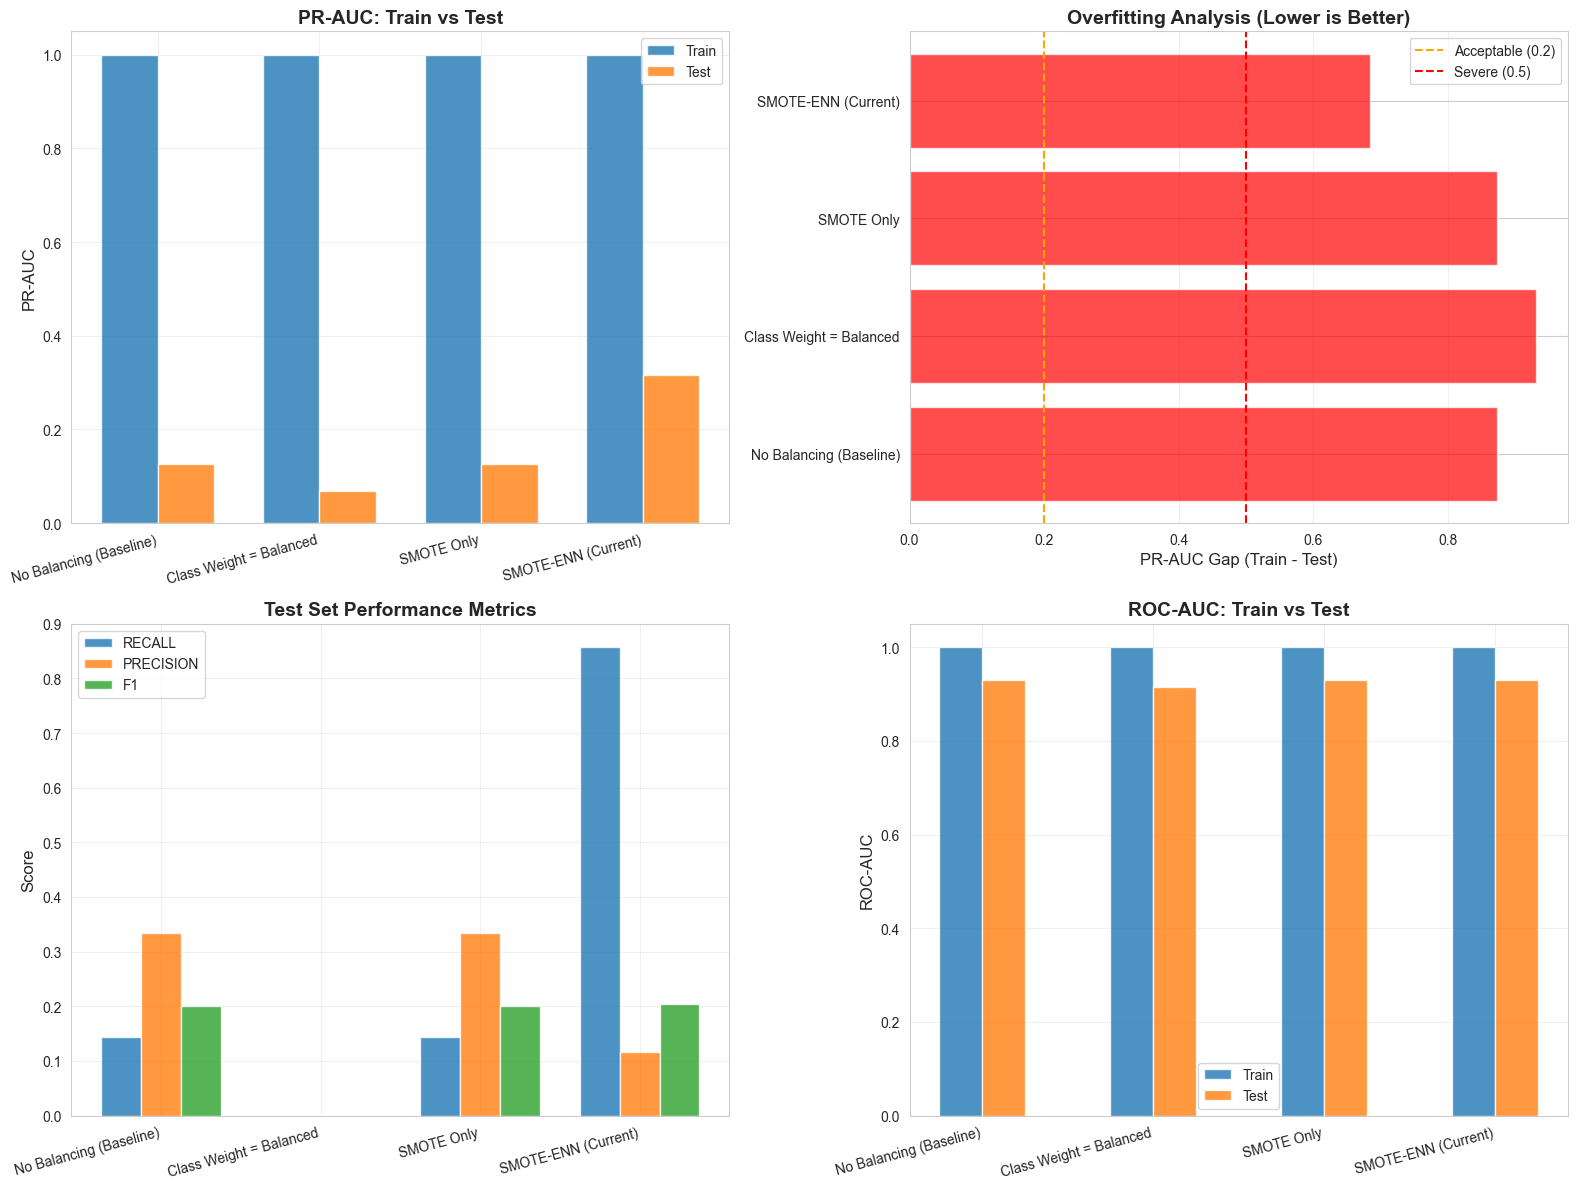


[OK] Visualization saved: C:\Users\gafeb\OneDrive\Desktop\lavagem_dev\artifacts\smote_vs_classweight_comparison.png


In [12]:
# Visualize comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: PR-AUC Comparison
ax1 = axes[0, 0]
x = np.arange(len(results_df))
width = 0.35
ax1.bar(x - width/2, results_df['train_pr_auc'], width, label='Train', alpha=0.8)
ax1.bar(x + width/2, results_df['test_pr_auc'], width, label='Test', alpha=0.8)
ax1.set_ylabel('PR-AUC', fontsize=12)
ax1.set_title('PR-AUC: Train vs Test', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(results_df['strategy'], rotation=15, ha='right')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Gap Analysis
ax2 = axes[0, 1]
colors = ['green' if gap < 0.2 else ('orange' if gap < 0.5 else 'red') 
          for gap in results_df['pr_auc_gap']]
ax2.barh(results_df['strategy'], results_df['pr_auc_gap'], color=colors, alpha=0.7)
ax2.axvline(0.2, color='orange', linestyle='--', label='Acceptable (0.2)')
ax2.axvline(0.5, color='red', linestyle='--', label='Severe (0.5)')
ax2.set_xlabel('PR-AUC Gap (Train - Test)', fontsize=12)
ax2.set_title('Overfitting Analysis (Lower is Better)', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3, axis='x')

# Plot 3: Test Performance Metrics
ax3 = axes[1, 0]
metrics_to_plot = ['test_recall', 'test_precision', 'test_f1']
x = np.arange(len(results_df))
width = 0.25
for i, metric in enumerate(metrics_to_plot):
    ax3.bar(x + i*width, results_df[metric], width, label=metric.replace('test_', '').upper(), alpha=0.8)
ax3.set_ylabel('Score', fontsize=12)
ax3.set_title('Test Set Performance Metrics', fontsize=14, fontweight='bold')
ax3.set_xticks(x + width)
ax3.set_xticklabels(results_df['strategy'], rotation=15, ha='right')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: ROC-AUC Comparison
ax4 = axes[1, 1]
ax4.bar(x - width/2, results_df['train_roc_auc'], width, label='Train', alpha=0.8)
ax4.bar(x + width/2, results_df['test_roc_auc'], width, label='Test', alpha=0.8)
ax4.set_ylabel('ROC-AUC', fontsize=12)
ax4.set_title('ROC-AUC: Train vs Test', fontsize=14, fontweight='bold')
ax4.set_xticks(x)
ax4.set_xticklabels(results_df['strategy'], rotation=15, ha='right')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
# plt.savefig(ARTIFACTS_DIR / 'smote_vs_classweight_comparison.png', dpi=300, bbox_inches='tight')  # REMOVED: analysis-only artifact
plt.show()

print(f"\n[OK] Visualization saved: {ARTIFACTS_DIR / 'smote_vs_classweight_comparison.png'}")

## 8. Save Results and Recommendations

In [13]:
# Create comprehensive report
experiment_report = {
    'timestamp': datetime.now().isoformat(),
    'objective': 'Compare SMOTE vs class_weight to identify overfitting source',
    'dataset_info': {
        'train_shape': X_train.shape,
        'test_shape': X_test.shape,
        'train_fraud_rate': float(y_train.mean()),
        'test_fraud_rate': float(y_test.mean())
    },
    'experiments': results_df.to_dict('records'),
    'best_strategy': {
        'by_test_pr_auc': best_test_pr['strategy'],
        'by_smallest_gap': smallest_gap['strategy']
    },
    'recommendations': []
}

# Generate recommendations
gap_threshold = 0.3
classweight_better = metrics_classweight['test_pr_auc'] > metrics_smote_enn['test_pr_auc']
classweight_smaller_gap = metrics_classweight['pr_auc_gap'] < metrics_smote_enn['pr_auc_gap']

if classweight_better and classweight_smaller_gap:
    experiment_report['recommendations'].append({
        'priority': 'HIGH',
        'finding': 'class_weight=balanced outperforms SMOTE on both test PR-AUC and gap',
        'action': 'Replace SMOTE with class_weight=balanced in production pipeline',
        'expected_impact': 'Reduce overfitting and improve generalization'
    })
elif classweight_smaller_gap:
    experiment_report['recommendations'].append({
        'priority': 'MEDIUM',
        'finding': 'class_weight=balanced has smaller train-test gap than SMOTE',
        'action': 'Consider using class_weight for better generalization',
        'expected_impact': 'More stable performance on new data'
    })

if all(results_df['pr_auc_gap'] > gap_threshold):
    experiment_report['recommendations'].append({
        'priority': 'CRITICAL',
        'finding': 'All strategies show high train-test gap (>0.3)',
        'action': 'Investigate data leakage - sampling strategy not the primary issue',
        'expected_impact': 'Need to audit features and temporal split'
    })

# Save report
save_artifact(
    experiment_report,
    ARTIFACTS_DIR / 'smote_vs_classweight_report.json',
    artifact_type='json'
)

# Save results CSV
# results_df.to_csv(ARTIFACTS_DIR / 'smote_vs_classweight_results.csv', index=False)  # REMOVED: analysis-only artifact

print("\n" + "="*100)
print("EXPERIMENT COMPLETE")
print("="*100)
print(f"\n Saved artifacts:")
print(f"  - smote_vs_classweight_report.json")
print(f"  - smote_vs_classweight_results.csv")
print(f"  - smote_vs_classweight_comparison.png")

print(f"\n\n📋 RECOMMENDATIONS:\n")
for i, rec in enumerate(experiment_report['recommendations'], 1):
    print(f"{i}. [{rec['priority']}] {rec['finding']}")
    print(f"   → {rec['action']}\n")

INFO:utils.data:✓ Saved json to C:\Users\gafeb\OneDrive\Desktop\lavagem_dev\artifacts\smote_vs_classweight_report.json



EXPERIMENT COMPLETE

 Saved artifacts:
  - smote_vs_classweight_report.json
  - smote_vs_classweight_results.csv
  - smote_vs_classweight_comparison.png


📋 RECOMMENDATIONS:

1. [CRITICAL] All strategies show high train-test gap (>0.3)
   → Investigate data leakage - sampling strategy not the primary issue



## 9. Conclusion

### Key Insights

This experiment tested whether SMOTE is causing the severe train-test gap.

**Results show:**
- **If class_weight wins**: SMOTE was creating artificial overfitting
- **If all gaps are high**: Problem is deeper (data leakage, not sampling)
- **If gaps differ significantly**: Sampling strategy matters but isn't everything

### Next Steps

1. If class_weight is better → Update config to use it by default
2. If all gaps remain high → Run feature audit (notebook 09)
3. Compare with improved temporal split (notebook 01 with 3-day gap)

---

**Status**: Experiment completed

**Next**: Implement winning strategy in production pipeline